In [1]:
# Import libraries
import numpy as np

rng = np.random.default_rng(1)
import seaborn as sns
import matplotlib.pyplot as plt

# Adaptive Localization

Parameter estimation using few samples (realizations) leads to sampling errors and spurious correlations (see section below), which can lead to inaccurately strong updates during the estimation process.
A strong update, characterized by a posterior with low variance, can be misleading - essentially leading to confident but potentially incorrect conclusions.
Localization is a widely used method to mitigate this.

Localization uses only observations deemed close when updating a subset of adjacent parameters.
The process involves two key decisions: determining what constitutes adjacent parameters and defining a measure of closeness.
This document considers only two such measures of closeness.
Namely, the Euclidean distance and Pearson's correlation coefficient.

- **Localization - Step-by-Step:**
    - **Select Adjacent Parameters:** Identify a subset of adjacent parameters. Subset may consist of a single parameter.
    - **Identify Close Observations:** Choose observations that are near this subset.
        Closeness can be defined in various ways.
    - **Update:** Use only close observations in the update step.


## Distance-Based Localization - Euclidean Distance as a measure of closeness

In distance-based localization, closeness is measured by Euclidean distance which is analogous to measuring straight-line distances in physical space.
The simplest way to set-up distance based localization is to define a radius of influence around every parameter.
Only observations within this radius of influence are used in updates.
The figure below illustrates this approach.


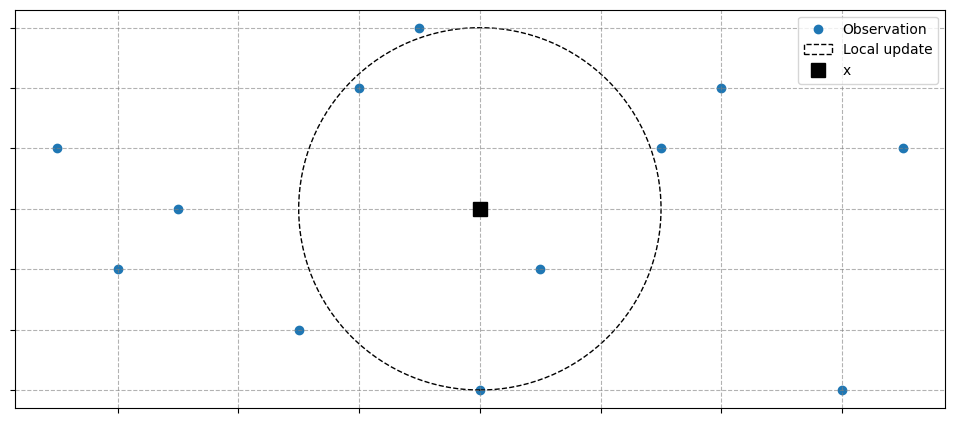

In [2]:
# Create schematic representation of Distance-Based Localization
observations = np.array(
    [
        [1, 5],
        [2, 3],
        [3, 4],
        [5, 2],
        [6, 6],
        [7, 7],
        [8, 1],
        [9, 3],
        [11, 5],
        [12, 6],
        [14, 1],
        [15, 5],
    ]
)

# Define the center of the local update area
local_update_center = (8, 4)

# Define the radius for the local update circle
radius = 3

fig, ax = plt.subplots(figsize=(12, 12))

ax.scatter(observations[:, 0], observations[:, 1], label="Observation")

# Plot the local update area
circle = plt.Circle(
    local_update_center,
    radius,
    color="k",
    fill=False,
    linestyle="--",
    label="Local update",
)
ax.add_artist(circle)

# Highlight the point 'x' with a square marker inside the circle
ax.plot(local_update_center[0], local_update_center[1], "ks", markersize=10, label="x")

ax.grid(True, linestyle="--", which="both", color="grey", alpha=0.6)

ax.set_aspect("equal")

ax.set_xticklabels([])
ax.set_yticklabels([])

_ = ax.legend()

How big should the circle be? Should all observations within the circle influence the update by the same amount, or should near-by observations have a bigger impact than those further away? It is labour intensive to give good answers to these questions which is a disadvantage of distance-based localization.
An alternative that requires much less user-input is `adaptive localization` where the measure of closeness is not that of Euclidean distance, but instead Person's correlation coefficient.

## Adaptive-Localization - Pearson Correlation as measure of closeness

As mentioned, the key difference between distance-based localization and adaptive-localization is the measure of closeness.

- **Adaptive Localization step-by-step:**
    - Select a subset of adjacent parameters
    - Choose responses that are significantly correlated to these parameters
    - Update using only observations that correspond to these responses

Adaptive localization's main benefit is its user-friendliness, as it primarily requires users to set the `correlation threshold`, which is optional.

## Enabling via the GUI

In `ERT`, activate adaptive localization by ticking the `Adaptive localization correlation threshold` checkbox.
This enables it for the entire experiment, meaning it will run for every iteration of, say, `ES-MDA`.
While the correlation threshold can be manually set, `ERT` determines a sensible default based on the size of the ensemble.
At a threshold of 0.0, the update will be identical to no localization, while at 1.0, it results in the posterior being identical to the prior, hence no update.

![](ert_screenshot_adaptive_loc.png)

## Enabling via Configuration File (Applicable to both CLI and GUI)

To enable adaptive localization using the config file, insert:

```
ANALYSIS_SET_VAR STD_ENKF LOCALIZATION True
```

This setting activates adaptive localization for both CLI and GUI executions.

To manually set the localization threshold via the config-file, include:

```
ANALYSIS_SET_VAR STD_ENKF LOCALIZATION_CORRELATION_THRESHOLD 1.0
```

## Computational Considerations

Be aware that adaptive localization comes with significant computational costs, which depend on two factors:

- The number of parameters: More parameters lead to longer run times.
- The correlation threshold: A higher threshold reduces computational time. \
    Increasing the threshold makes it less likely that a parameter and a response are considered significantly correlated. \
    This makes it less likely that a parameter needs to be updated at all which reduces the computational cost.


## Spurious Correlations

Spurious correlations refer to relationships that emerge between two variables that are not causally related, yet appear to be connected due to coincidence, a third variable, or a fluke in the data.
The term `spurious` suggests that the correlation is misleading or deceptive.
Often, these correlations are the result of random chance, especially in small data samples.
This is illustrated in the two figures below.
On the left-hand side, 10 samples are drawn from a multivariate normal distributions with 5 independent parameters.
If there were no spurious correlations, all correlations would be 0 because the parameters are independent.
As we draw more samples, the correlations tend towards zero as shown in the right-hand side figure.


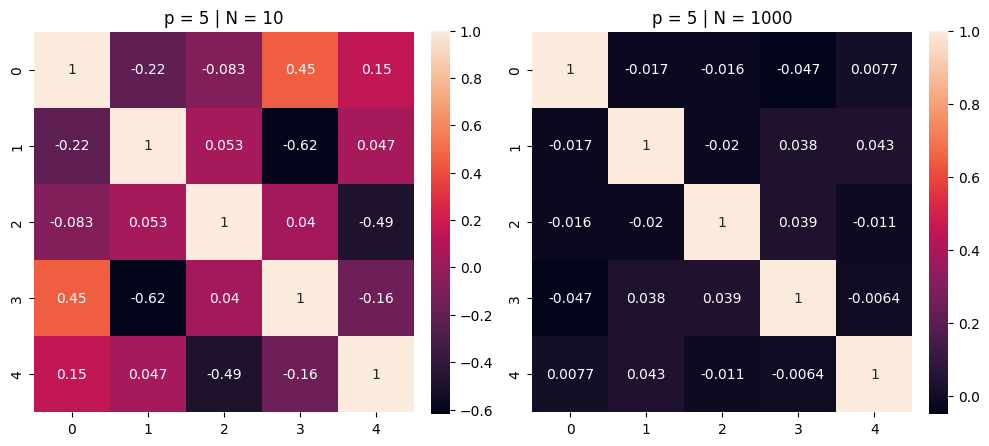

In [3]:
# Illustrate effect of spurious correlations
p = 5
mean = np.zeros(p)
cov = np.identity(p)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i, N in enumerate([10, 1000]):
    X = rng.multivariate_normal(mean, cov, size=N).T
    corr_matrix = np.corrcoef(X)
    sns_heatmap = sns.heatmap(
        corr_matrix,
        annot=True,
        ax=ax[i],
        square=True,
        cbar_kws={"fraction": 0.046, "pad": 0.04},
    )

    # Adjust the colorbar size to match the figure height
    cbar = sns_heatmap.collections[0].colorbar
    loc = plt.FixedLocator(cbar.get_ticks())
    cbar.ax.yaxis.set_major_locator(loc)
    cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), rotation=0)

    ax[i].set_title(f"p = {p} | N = {N}")
fig.tight_layout()